# Week 4: BBC News Classification Kaggle Mini-Project

Data Science Student, University of Colorado, Boulder

In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import MinMaxScaler

The data for this project comes from the Kaggle BBC News classification competition:

> https://www.kaggle.com/competitions/learn-ai-bbc/overview

The goal of the project is to classify BBC articles based on their content into one of five different categories.  This will be attempted using both unsupervised and supervised machine learning methods.

Kaggle provides both labeled training data, as well as unlabeled test data.  These will be loaded into Pandas dataframes for analysis.

In [8]:
train_data = pd.read_csv('BBC News Train.csv')
test_data = pd.read_csv('BBC News Test.csv')

# Exploratory Data Analysis

In [10]:
train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


The training data includes 1490 objects with three features: ArticleId, Text, and Category.  There are no null values.  The text feature includes what appears to be the full text of an article in lowercase letters.  Some punctuation is present; however, it looks like some periods/apostrophes/etc have been removed.  Below we can see that there are 5 categories of articles: Business, Entertainment, Politics, Sports, and Technology.  The data is roughly balanced, but business and sports do have more articles.

In [12]:
train_data["Text"][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [14]:
train_counts = train_data.groupby('Category').count()
print(train_counts["Text"])

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: Text, dtype: int64


<Axes: xlabel='Category'>

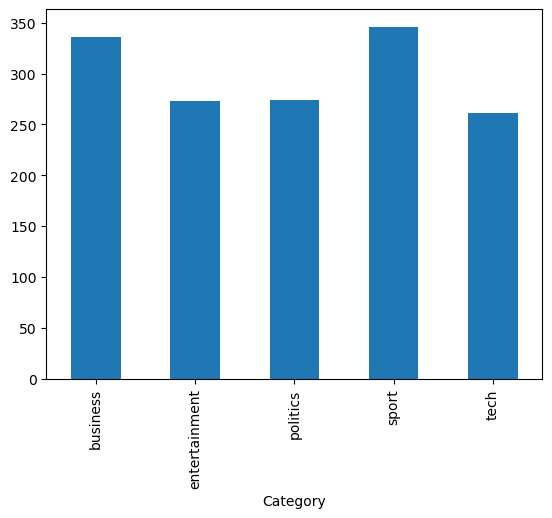

In [15]:
train_counts["Text"].plot(kind='bar')

In [16]:
text_lengths = []

for row in train_data["Text"].astype(str):
    text_lengths.append(len(row))

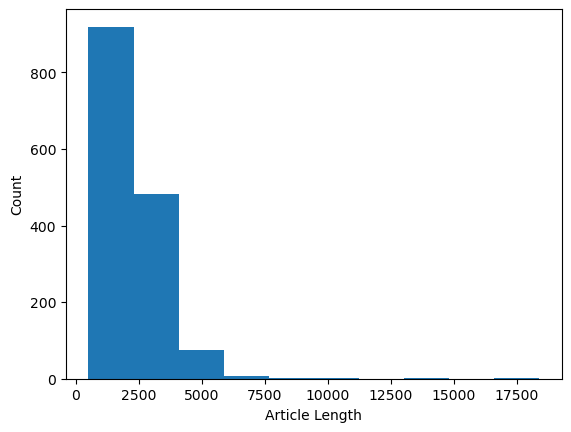

In [17]:
plt.hist(text_lengths)
plt.xlabel('Article Length')
plt.ylabel('Count')
plt.show()

The histogram above shows that most of the articles have lengths less than 5,000 characters; however, there are a handful that can be as long as 17,500 characters.

To prepare the data for modeling, I will separate the training data into X and y segments.  Since the data is in the form of articles, it is not initially very useful for training a model.  A good approach will be to transform each article into a vector of word frequencies, and then these word frequency vectors can be used to train the models.  Since I will need to vectorize the data, I will remove the ArticleId. 

In [499]:
X_train = train_data.drop(['Category', 'ArticleId'], axis=1)
y_train = train_data.drop('Text', axis=1)

X_test = test_data.copy()

I will also write a function to find the best correspondence between the model results and the article categories

In [503]:
def label_permute_compare(yt,yp,n=5):
    
    best_accuracy = 0
    best_order = []
    
    news_label = ['business', 'sport', 'tech', 'entertainment', 'politics']
    
    poss_orders = set(itertools.permutations(range(n)))

    for poss_order in poss_orders:
        label_test = yt.copy()
        label_test = label_test.replace(news_label, poss_order)
        label_test = label_test['Category'].tolist()
        accuracy = accuracy_score(label_test,yp)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_order = poss_order

    label_match = {}
    for i in range(len(news_label)):
        label_match[best_order[i]] = news_label[i]
    keys = list(label_match.keys())
    keys.sort()
    sorted_dict = {i: label_match[i] for i in keys}

    labeled_data = yt.copy()
    labeled_data = labeled_data.replace(news_label, best_order)
    labeled_data = labeled_data['Category'].tolist()

    print(sorted_dict)
    print("Accuracy: " + str(best_accuracy))    
    print("Precision: " + str(precision_score(labeled_data,yp, average='weighted')))
    print("Recall: " + str(recall_score(labeled_data,yp, average='weighted')))
    print("F Score: " + str(f1_score(labeled_data,yp, average='weighted')))
    print("Confusion Matrix: \n")

    cm = confusion_matrix(labeled_data,yp)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    

In [504]:
def strongest_features(W):
    y_pred = []

    for row in W:
        y_pred.append(np.argmax(row))
    return y_pred

# Unsupervised Learning: Non-Negative Matrix Factorization

For the first part of this machine learning project, I will use Non-Negative Matrix Factorization to train and predict.  To accomplish this it will be necessary to vectorize each of the articles.  I initially used Sklearn's CountVectorizer function to accomplish this; however, I found that I could achieve much better results by using the TfidfVectorizer function.  This achieves the same task as CountVectorizer, but it also normalizes the data while providing some additional functionality in selecting the scope of the data to be used.  "Tfidf" stands for Term-Frequency Times Inverse Document-Frequency, which allows very frequent words to be given less weight.  

I will then apply Non-Negative Matrix Factorization with 5 components, to match the 5 article categories that we are searching for in the data.

In [500]:
All_X = X_train["Text"].append(X_test["Text"], ignore_index=True)
X_all_np = np.array(All_X)

C:\Users\stephen\AppData\Local\Temp\ipykernel_19856\2774471754.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_X = X_train["Text"].append(X_test["Text"], ignore_index=True)


In [501]:
tfidf_vectors = TfidfVectorizer(stop_words = 'english')
tfidf_transform = tfidf_vectors.fit_transform(X_all_np)

In [574]:
tfidf_transform.shape

(2225, 12761)

In [614]:
words = tfidf_vectors.get_feature_names_out()

In [632]:
word_values = tfidf_transform.sum(0)

In [633]:
word_values_arr = np.array(word_values)

In [634]:
word_indices = word_values_arr[0].argsort()[-50:][::-1]

In [635]:
words[word_indices]

array(['election', 'blair', 'economy', 'sales', 'tv', 'economic',
       'report', 'services', 'club', 'match', 'figures', 'net', 'france',
       'december', 'firms', 'brown', 'bank', 'office', 'state', 'star',
       'users', 'cup', 'president', 'season', 'player', 've', 'tax',
       'rise', 'playing', 'played', 'shares', 'analysts', 'nations',
       'court', 'campaign', 'mobile', 'sunday', 'prime', 'return',
       'offer', 'man', 'united', 'wales', 'howard', 'cut', 'information',
       'digital', 'foreign', 'cost', 'leader'], dtype=object)

In [ ]:
train_counts["Text"].plot(kind='bar')

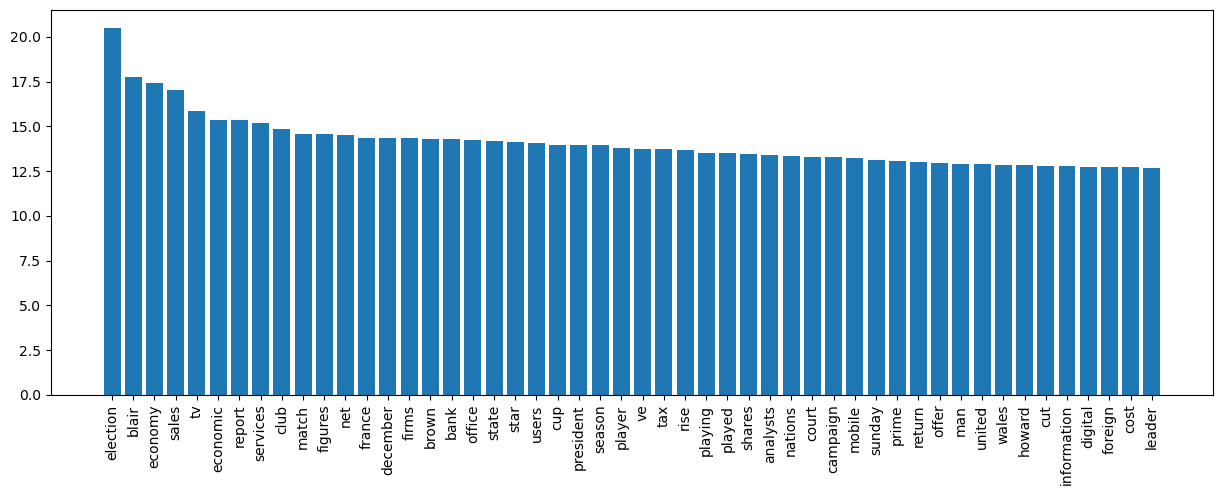

In [642]:
plt.figure(figsize=(15,5))
plt.bar(words[word_indices], word_values_arr[0][word_indices])
plt.xticks(rotation = 90)
plt.show()

It looks like the vectorizer is doing its job.  Words with the top values are all meaningful words that should help to classify articles.   

The matrix on which the model is being trained is taking into account 29,126 different words.  In later iterations, we will attempt to reduce the number of words considered.

In [25]:
nmf_model = NMF(n_components=5, random_state=0)
W = nmf_model.fit_transform(tfidf_transform)

For each article, we want to choose the feature with the highest value in the matrix (W) as our prediction.  This will be accomplished with the strongest_features function.  Then it is necessary to permute the possible categories to obtain the best match to the data.  This will be accomplished through the label_permute_compare function.

{0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'business'}
Accuracy: 0.9140939597315436
Precision: 0.9161101224802226
Recall: 0.9140939597315436
F Score: 0.91339159250072
Confusion Matrix: 



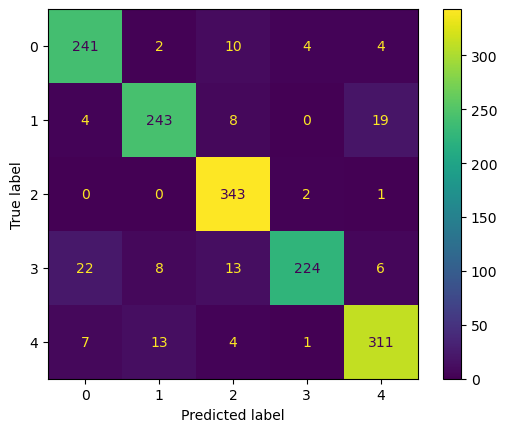

In [26]:
label_permute_compare(y_train,strongest_features(W)[:1490])

Without any hyperparameter selection, we have accomplished a decent model which achieves an accuracy over 91%.  The confusion matrix shows that Business gets confused with Politics; Tech gets confused with Entertainment.  I will now attempt to select parameters for both the TfidfVectorizer and NMF to achieve better results.  First I will select thresholds for words based on document frequency.  This will remove very frequent and very infrequent words from the model.  

{0: 'tech', 1: 'politics', 2: 'sport', 3: 'business', 4: 'entertainment'}
Accuracy: 0.9429530201342282
Precision: 0.9434792607067198
Recall: 0.9429530201342282
F Score: 0.9426606691450602
Confusion Matrix: 



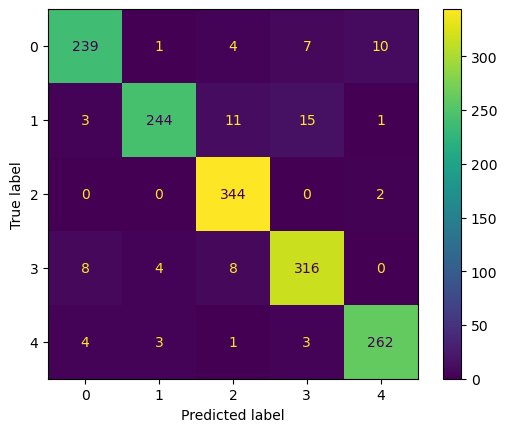

In [27]:
tfidf_vectors = TfidfVectorizer(stop_words = 'english', max_df=.1, min_df=.001)
tfidf_transform = tfidf_vectors.fit_transform(X_all_np)
nmf_model = NMF(n_components=5, random_state=0)
W = nmf_model.fit_transform(tfidf_transform)
label_permute_compare(y_train,strongest_features(W)[:1490])

After adjusting theshold values, I found this to be the best combination.  This reduces the number of the words in training matrix to 2,225. Accuracy increased to over 94%.  The default Normalization parameter is L2, and this is also achieves the best results.  L2 Normalization means that if the values were squared and added together, they would equal 1.  

{0: 'tech', 1: 'sport', 2: 'politics', 3: 'business', 4: 'entertainment'}
Accuracy: 0.959731543624161
Precision: 0.960144254587225
Recall: 0.959731543624161
F Score: 0.9596754149799698
Confusion Matrix: 



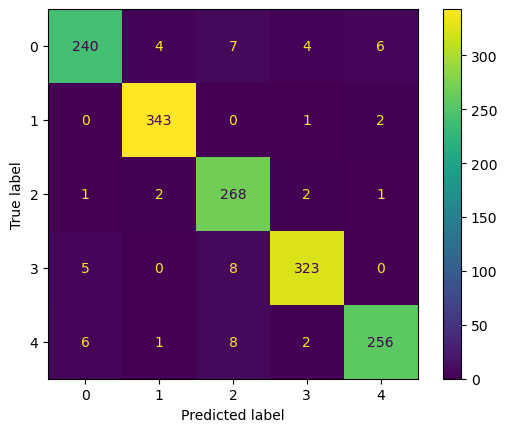

In [28]:
tfidf_vectors = TfidfVectorizer(stop_words = 'english', max_df=.1, min_df=.001, sublinear_tf=True)
tfidf_transform = tfidf_vectors.fit_transform(X_all_np)
nmf_model = NMF(n_components=5, random_state=0)
W = nmf_model.fit_transform(tfidf_transform)
label_permute_compare(y_train,strongest_features(W)[:1490])

Now, I have added sublinear scaling to the TfidfVectorizer, and this has further increased the performance of the model.  I will now adjust the values for the NMF model.

{0: 'tech', 1: 'sport', 2: 'politics', 3: 'business', 4: 'entertainment'}
Accuracy: 0.9610738255033557
Precision: 0.9622723909429335
Recall: 0.9610738255033557
F Score: 0.9611922798055238
Confusion Matrix: 



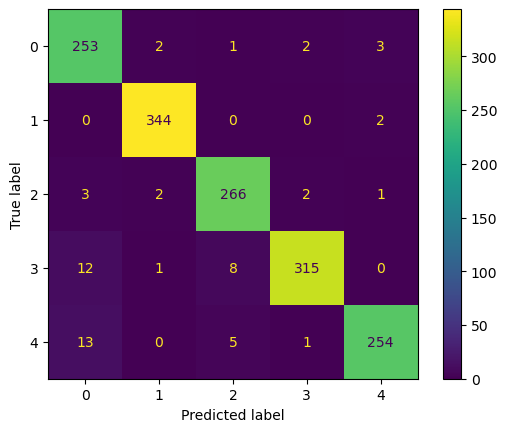

In [29]:
tfidf_vectors = TfidfVectorizer(stop_words = 'english', max_df=.1, min_df=.001, sublinear_tf=True)
tfidf_transform = tfidf_vectors.fit_transform(X_all_np)
nmf_model = NMF(n_components=5, random_state=0, solver='mu')
W = nmf_model.fit_transform(tfidf_transform)
label_permute_compare(y_train,strongest_features(W)[:1490])


The Multiplicative Update solver provides better results than Coordinate Descent.  Below we see that using a random matrix as the initial state provides further improvement.

{0: 'sport', 1: 'business', 2: 'tech', 3: 'entertainment', 4: 'politics'}
Accuracy: 0.961744966442953
Precision: 0.9623411505973939
Recall: 0.961744966442953
F Score: 0.9618255483987928
Confusion Matrix: 



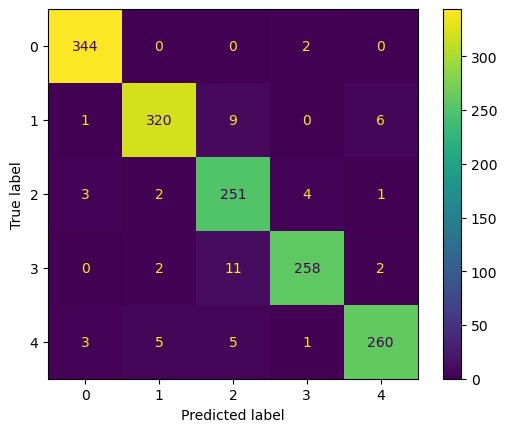

In [30]:
tfidf_vectors = TfidfVectorizer(stop_words = 'english', max_df=.1, min_df=.001, sublinear_tf=True)
tfidf_transform = tfidf_vectors.fit_transform(X_all_np)
nmf_model = NMF(n_components=5, random_state=0, solver='mu', init='random')
W = nmf_model.fit_transform(tfidf_transform)
label_permute_compare(y_train,strongest_features(W)[:1490])

<b>Submitting my test predictions to Kaggle, I achieved a score of 0.94829 on the test data using this NMF method.</b>

# Supervised Learning Models

To prepare supervised models for comparison, I have written another function before to provide scoring.

In [10]:
def score(y_test, y_pred):
    print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
    print("Precision: " + str(precision_score(y_test, y_pred, average='weighted')))
    print("Recall: " + str(recall_score(y_test, y_pred, average='weighted')))
    print("F Score: " + str(f1_score(y_test, y_pred, average='weighted')))
    print("Confusion Matrix: \n")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

I will then append the train and test articles together, so that they can all be vectorized together.  This ensures that they will have the same feature matrix structure for training and testing.  I will also replace the category values with integers.  This will facilitate scoring later.  

In [11]:
X = X_train["Text"].append(X_test["Text"], ignore_index=True)
y = train_data["Category"]

X = np.array(X)
y = y.replace(['business', 'sport', 'tech', 'entertainment', 'politics'], [0, 1, 2, 3, 4])

C:\Users\stephen\AppData\Local\Temp\ipykernel_19856\1930900484.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X_train["Text"].append(X_test["Text"], ignore_index=True)


Now I vectorize the data.

In [12]:
tfidf_vectors = TfidfVectorizer(stop_words = 'english')
X_tfidf = tfidf_vectors.fit_transform(X)

## Random Forest Algorithm

I was reflecting that with such a big matrix of data, it would likely be good to take advantage of the bagging and feature sampling properties of Random Forest.  Indeed, the algorithm did perform well on the data, with good performance.  I used grid search to find the best parameters for max depth and the number of estimators.

In [34]:
rf = RandomForestClassifier(class_weight='balanced', random_state=0)

parameters = {'max_depth':[1,2,3,4,5],'n_estimators':[50,100,150,200,250,300]}
grid = GridSearchCV(rf, parameters, cv=3)

In [ ]:
grid.fit(X_tfidf[:1192], y[:1192])

In [ ]:
grid.best_params_

In [35]:
rf = RandomForestClassifier(max_depth=4, n_estimators=300, class_weight='balanced', random_state=0).fit(X_tfidf[:1192], y[:1192])

I will test the model on 20% of the Kaggle data, which I did not use for training.   

In [36]:
y_pred = rf.predict(X_tfidf[1193:1490])

Accuracy: 0.9663299663299664
Precision: 0.967207559465624
Recall: 0.9663299663299664
F Score: 0.9663520962195865
Confusion Matrix: 



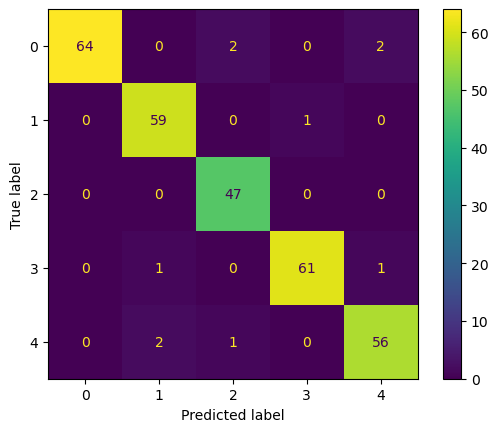

In [37]:
score(y[1193:1490], y_pred)

<b>The Random Forest method scored 0.95918 on Kaggle using Random Forest</b>

I will now test the model using fewer labels for comparison purposes

#### Random Forest: 50% of Data

In [475]:
rf = RandomForestClassifier(max_depth=4, n_estimators=300, class_weight='balanced', random_state=0).fit(X_tfidf[:596], y[:596])

In [476]:
y_pred = rf.predict(X_tfidf[1193:1490])

Accuracy: 0.9629629629629629
Precision: 0.9641216587645158
Recall: 0.9629629629629629
F Score: 0.963039721652052
Confusion Matrix: 



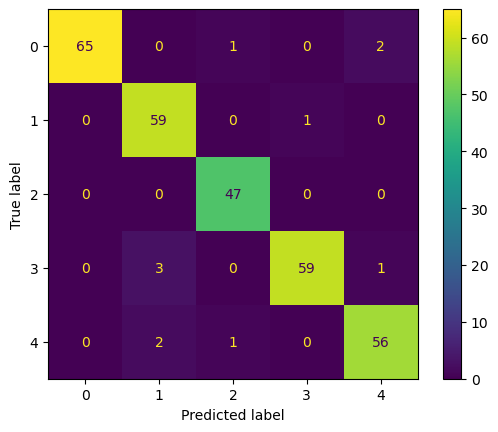

In [477]:
score(y[1193:1490], y_pred)

#### Random Forest: 25% of Data

In [478]:
rf = RandomForestClassifier(max_depth=4, n_estimators=300, class_weight='balanced', random_state=0).fit(X_tfidf[:298], y[:298])

In [479]:
y_pred = rf.predict(X_tfidf[1193:1490])

Accuracy: 0.9259259259259259
Precision: 0.9305639357642769
Recall: 0.9259259259259259
F Score: 0.9262025462076532
Confusion Matrix: 



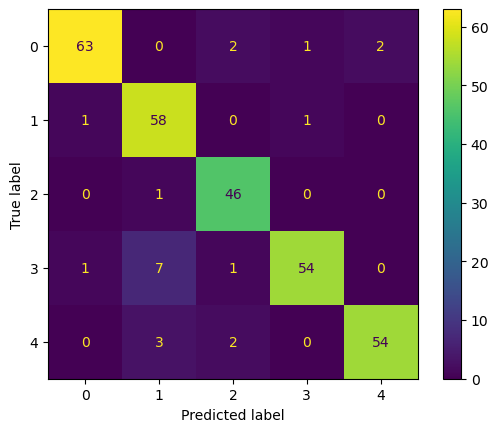

In [480]:
score(y[1193:1490], y_pred)

With 25% of the labels, the model still performed almost as it did with all them.  However, with 25% of the labels, it peformed about 5% worse.    

### Gradient Boosting Algorithm With SVD Dimensionality Reduction

Gradient Boosting had serious issues trying to train on the data.  In fact, Jupyter was timing out with all of the data, so I reduced the dimensions of the vectorized data by using SVD.  I was able to run Gradient Boosting, but it took well over 10 minutes to train.  I reduced the data to 1000 components, but this only captured about 78% of the information within the data.  Therefore, the model performed worse than the others.  This technique wasn't able to handle the large number of features in an efficient way.  

In [43]:
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)

In [44]:
svd.fit(X_tfidf.T)

TruncatedSVD(n_components=1000, n_iter=7, random_state=42)

In [45]:
svd.explained_variance_ratio_.sum()

0.7789248841715198

In [50]:
vectors = svd.components_

In [53]:
vectors = vectors.T

In [481]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.01,max_depth=2, random_state=0).fit(vectors[:1192], y[:1192])

In [58]:
y_pred = gbc.predict(vectors[1193:1490])

Accuracy: 0.9292929292929293
Precision: 0.9316994115107607
Recall: 0.9292929292929293
F Score: 0.9299409574967816
Confusion Matrix: 



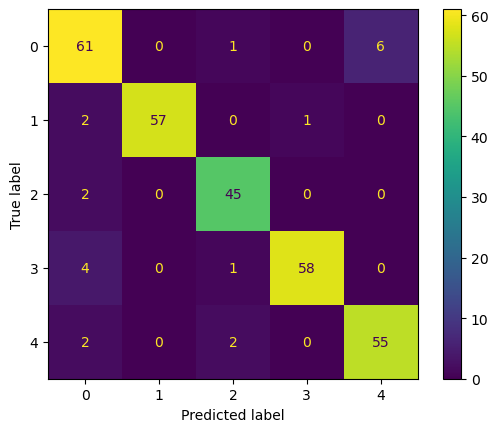

In [61]:
score(y[1193:1490], y_pred)

<b>The Gradient Boosting scored 0.90068 on Kaggle</b>

#### Gradient Boosting: 50% of Data

In [482]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.01,max_depth=2, random_state=0).fit(vectors[:596], y[:596])

In [483]:
y_pred = gbc.predict(vectors[1193:1490])

Accuracy: 0.9090909090909091
Precision: 0.9146540569089587
Recall: 0.9090909090909091
F Score: 0.9102477438401149
Confusion Matrix: 



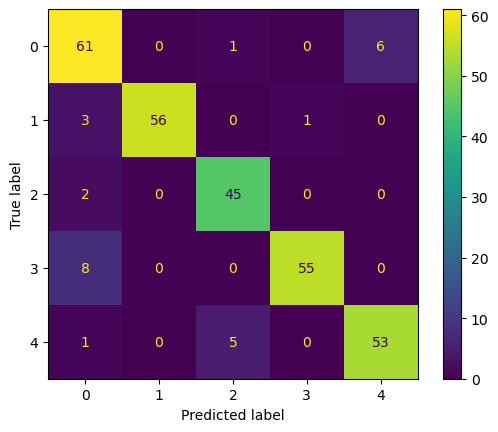

In [484]:
score(y[1193:1490], y_pred)

#### Gradient Boosting: 25% of Data

In [485]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.01,max_depth=2, random_state=0).fit(vectors[:298], y[:298])

In [486]:
y_pred = gbc.predict(vectors[1193:1490])

Accuracy: 0.9259259259259259
Precision: 0.9265466154006733
Recall: 0.9259259259259259
F Score: 0.9256197889556649
Confusion Matrix: 



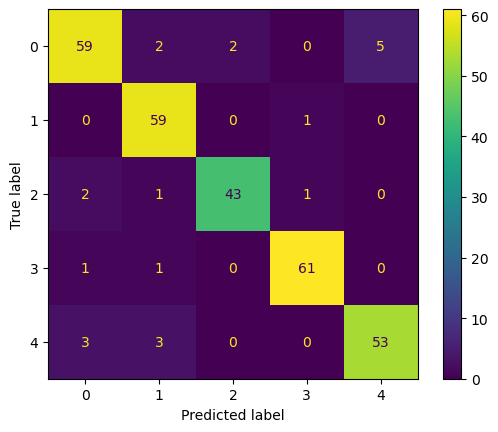

In [487]:
score(y[1193:1490], y_pred)

Strangely, the model performed better with 25% of the labels than it did with 50%.  This was likely anamolous.  

## Support Vector Machines

Lastly, I wanted to test Support Vector Machines on the data.  I was skeptical that it would perform well, as there would need to be a lot of distance calculations.  However, I was surprised that it performed the best of any of the algorithms that I tested.  It also trained quickly.  It scored the highest on the test data as well.    

In [91]:
svc = SVC(kernel='sigmoid')

parameters = {'C':[2**-5, 2**-4, 2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3, 2**4, 2**5]}
grid= GridSearchCV(svc, parameters,cv=3)

In [92]:
grid.fit(X_tfidf[:1192], y[:1192])

GridSearchCV(cv=3, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16, 32]})

I first tested each Kernel function without additional parameters to see which worked the best.  I found this to be the Sigmoid kernel.  Then I used a grid search to identify the best value for C. 

In [93]:
grid.best_params_

{'C': 1}

In [108]:
svm = SVC(kernel='sigmoid', C=1).fit(X_tfidf[:1192], y[:1192])

In [116]:
y_pred = svm.predict(X_tfidf[1193:1490])

Accuracy: 0.9696969696969697
Precision: 0.9700193663362455
Recall: 0.9696969696969697
F Score: 0.9697104007516695
Confusion Matrix: 



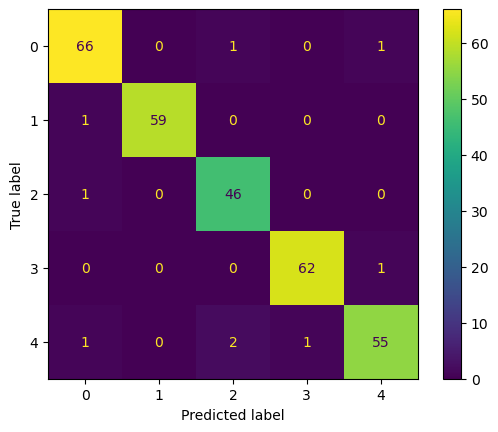

In [117]:
score(y[1193:1490], y_pred)

<b>The SVM model scored 0.97823 on Kaggle</b>

#### SVM: 50% of Data

In [488]:
svm = SVC(kernel='sigmoid', C=1).fit(X_tfidf[:596], y[:596])

In [489]:
y_pred = svm.predict(X_tfidf[1193:1490])

Accuracy: 0.9562289562289562
Precision: 0.9571062078281161
Recall: 0.9562289562289562
F Score: 0.9560588955793276
Confusion Matrix: 



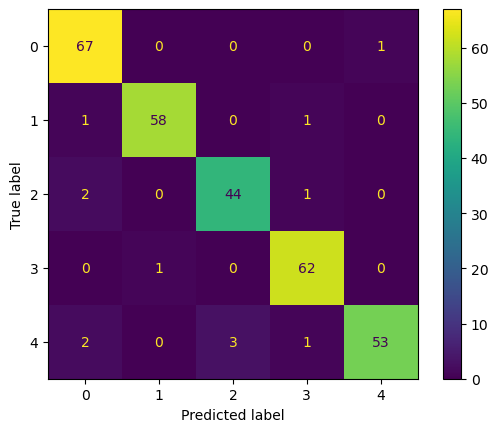

In [490]:
score(y[1193:1490], y_pred)

#### SVM: 25% of Data

In [491]:
svm = SVC(kernel='sigmoid', C=1).fit(X_tfidf[:298], y[:298])

In [492]:
y_pred = svm.predict(X_tfidf[1193:1490])

Accuracy: 0.9259259259259259
Precision: 0.9303031006063401
Recall: 0.9259259259259259
F Score: 0.9260517300638043
Confusion Matrix: 



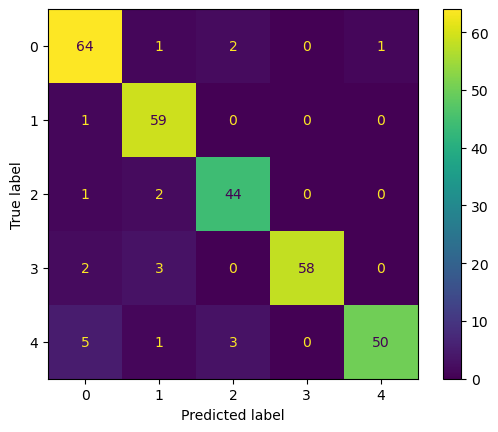

In [493]:
score(y[1193:1490], y_pred)

## Summary of Results

Non-Negative Matrix Factorization performed nearly as well as the best supervised learning methods, and it had the added benefit of not needing any labels to train the model.  With the exception of Gradient Boosting, the supervised learned methods lost more than 5% of their scores when the number of labels was reduced to 25% when they were evaluated on separate training data.  This suggests that when there is less data, the models are likely to become overfit.  This was not an issue with the unsupervised method, as no labeled data was used.  Gradient Boosting is a slower learner in general, and therefore, its performance was prohibitive with the increased number of features.  This was true even when the number of features was reduced with Singular Value Decomposition.  <br>

Overall, Support Vector Machines performed the best for the predictions that I submitted to Kaggle. Random Forest was the second best.  

|Method|Test Score|
|:----|:--------:|
|NMF with No Tuning | 0.913 |
|NMF with Reduced Word Count | 0.943 |
|NMF with Multiplicative Update | 0.962 |
|Random Forest | 0.966 |
|Random Forest 50% of Labels | 0.963 |
|Random Forest 25% of Labels | 0.926 |
|Gradient Boosting with SVD | 0.930 |
|Gradient Boosting/SVD 50% of Labels | 0.910 |
|Gradient Boosting/SVD 25% of Labels | 0.926 |
|Support Vector Machines | 0.970 |
|Support Vector Machines 50% of Labels| 0.956 |
|Support Vector Machines 25% of Labels | 0.926 |

|Method|Kaggle Score|
|:----|:--------:|
|NMF | 0.94829 |
|Random Forest | 0.95918 |
|Gradient Boosting with SVD | 0.90068 |
|Support Vector Machines | 0.97823 |


# References

>https://www.kaggle.com/competitions/learn-ai-bbc/overview <br>
>https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html <br>
>https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html<br>
>https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html <br>
>https://beckernick.github.io/matrix-factorization-recommender/<br>
>https://stats.stackexchange.com/questions/331926/explain-meaning-and-purpose-of-l2-normalization <br>
>https://en.wikipedia.org/wiki/Multiplicative_Weight_Update_Method <br>